# Take Home 6 - Unsupervised Learning

In [22]:
import pandas as pd
import sklearn
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, preprocessing,metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## K-means

In [2]:
fname = join(os.getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases
y = mat_contents['labels'].reshape(Nc)

Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

X1=[]
for i in range(0,850): # a regressão é realizada para extrair características de cada experimento, por isto são realizadas a extração de características 850 vezes
    pAR2 = AutoReg(Ch2[:,i], lags = 30).fit()
    pAR3 = AutoReg(Ch3[:,i], lags = 30).fit()
    pAR4 = AutoReg(Ch4[:,i], lags = 30).fit()
    pAR5 = AutoReg(Ch5[:,i], lags = 30).fit()
    result=np.concatenate([pAR2.params,pAR3.params,pAR4.params,pAR5.params])
    X1.append(result)

pca = PCA().fit(X1)
pca = decomposition.PCA(n_components=3) #variancia explicada 97%
X2 = pca.fit_transform(X1)
Nc,PCAcomp=X2.shape 

scaler = MinMaxScaler(feature_range=(-1,1))
X=scaler.fit_transform(X2)

indDam = y>9
df=pd.concat([pd.DataFrame(X),pd.DataFrame({'label':indDam})],axis=1)
df=df.replace(False,0)
df=df.replace(True,1)
df

,0,1,2,label
0,0.728961,-0.619964,-0.172817,0
1,0.617676,-0.718114,-0.275081,0
2,0.629277,-0.670517,-0.271454,0
3,0.666789,-0.908744,-0.696502,0
4,0.635523,-0.730507,-0.467551,0
...,...,...,...,...
845,-0.918601,-0.368052,0.176000,1
846,-0.898883,-0.588371,0.142308,1
847,-0.924074,-0.651231,-0.242938,1
848,-0.896291,-0.615915,-0.005804,1


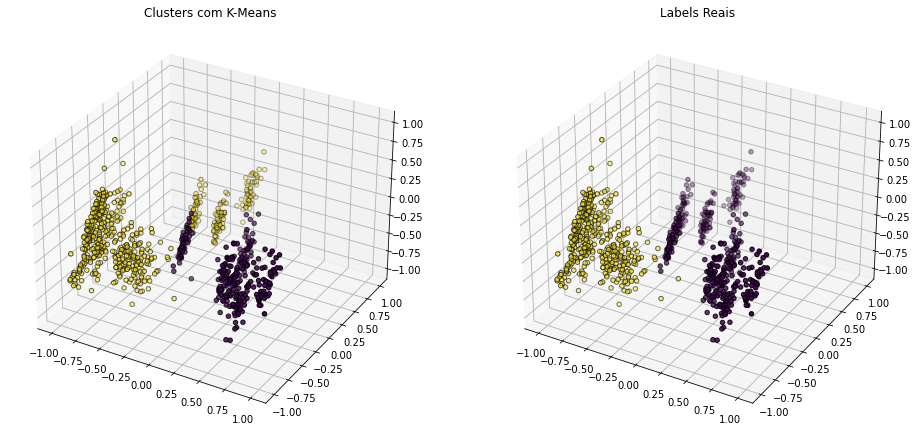

In [8]:
kmeans=KMeans(n_clusters=2, random_state=0).fit(X)
predict=kmeans.predict(X)

lbel=df['label']
labels = kmeans.labels_


fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(float), edgecolor="k")
ax1.set_title("Clusters com K-Means")

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.scatter(df[0], df[1], df[2], c=lbel.astype(float), edgecolor="k")
ax2.set_title("Labels Reais")

plt.show()


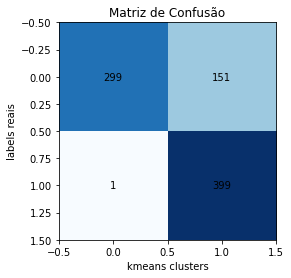

In [28]:
count_False = np.count_nonzero(labels == 0)
count_True = np.count_nonzero(labels == 1)
cm = confusion_matrix(lbel, labels)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans clusters")
plt.ylabel("labels reais")
plt.title("Matriz de Confusão")
plt.show()


## T-SNE

In [30]:
import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 850...
Computing P-values for point 500 of 850...
Mean value of sigma: 0.090727
Iteration 10: error is 17.077025
Iteration 20: error is 13.807995
Iteration 30: error is 11.936591
Iteration 40: error is 11.072063
Iteration 50: error is 10.791082
Iteration 60: error is 10.591213
Iteration 70: error is 10.481750
Iteration 80: error is 10.371822
Iteration 90: error is 10.301631
Iteration 100: error is 10.232088
Iteration 110: error is 0.861333
Iteration 120: error is 0.740792
Iteration 130: error is 0.647437
Iteration 140: error is 0.578533
Iteration 150: error is 0.527129
Iteration 160: error is 0.488336
Iteration 170: error is 0.458613
Iteration 180: error is 0.435435
Iteration 190: error is 0.417058
Iteration 200: error is 0.402237
Iteration 210: error is 0.390198
Iterati

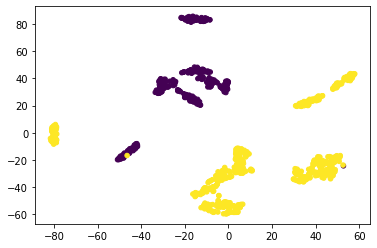

In [31]:
if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    Y = tsne(X, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
    pylab.show()

## One-class classification SVM

In [32]:
from sklearn.ensemble import IsolationForest

In [33]:
clf=IsolationForest(random_state=0).fit(X)
clf.predict()

TypeError: predict() missing 1 required positional argument: 'X'